#  PROGETTO FINALE IDS 

## Analisi e predizione dei risultati del campionato di Serie A 2023/2024

In questo progetto utilizzeremo un dataset della stagione di calcio della Serie A 2023/2024 per predire le ultime 5 giornate (dalla 33° alla 38°).

### Obiettivo del progetto
In un campionato con 20 squadre e un totale di 38 giornate, ogni squadra gioca 38 partite (una per giornata). Vogliamo considerare le ultime 5 giornate del campionato, quindi 50 partite in totale (10 partite per giornata × 5 giornate).

Per ciascuna partita, proveremo a prevedere il risultato usando uno dei seguenti segni:

- **1**: vittoria della squadra di casa
- **X**: pareggio
- **2**: vittoria della squadra in trasferta

In [76]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

## 1. Preparazione e pulizia dei dati

Importiamo la tabella Serie A_matches_23_24.csv, che contiene i risultati di tutte le partite del campionato, e visualizziamo le prime righe per comprendere la struttura dei dati.

In [77]:
matches = pd.read_csv('dataset/2021-2022.csv')
matches.head()

,Match Number,Round Number,Date,Location,Home Team,Away Team,Result
0,4,1,21/08/2021 18:30,Marcantonio Bentegodi,Hellas Verona,Sassuolo,2 - 3
1,5,1,21/08/2021 18:30,Giuseppe Meazza,Inter,Genoa,4 - 0
2,3,1,21/08/2021 20:45,Carlo Castellani,Empoli,Lazio,1 - 3
3,9,1,21/08/2021 20:45,Olimpico Grande Torino,Torino,Atalanta,1 - 2
4,1,1,22/08/2021 18:30,Renato Dall'Ara,Bologna,Salernitana,3 - 2


### Pulizia dei dati

Analizziamo le colonne del dataset e rimuoviamo quelle non necessarie:

In [78]:
matches.rename(columns={'Round Number': 'Round'}, inplace=True)
drop_columns = ['Date', 'Match Number' ,'Location']
matches.drop(drop_columns, axis=1, inplace=True)
matches.head()

,Round,Home Team,Away Team,Result
0,1,Hellas Verona,Sassuolo,2 - 3
1,1,Inter,Genoa,4 - 0
2,1,Empoli,Lazio,1 - 3
3,1,Torino,Atalanta,1 - 2
4,1,Bologna,Salernitana,3 - 2


In [79]:
# Verifichiamo la presenza di valori nulli
matches.isnull().sum()

Round        0
Home Team    0
Away Team    0
Result       0
dtype: int64

### Trasformazione dei dati

La colonna 'Score' presenta il punteggio in un'unica stringa. Procediamo a suddividerla in due colonne separate per una migliore analisi:
- **Score_casa**: gol segnati dalla squadra di casa
- **Score_trasferta**: gol segnati dalla squadra in trasferta

In [80]:
matches['Round'] = matches['Round'].astype(int)
matches[['Score_casa', 'Score_trasferta']] = matches['Result'].str.split('-', expand=True).astype(int)
matches.drop('Result', axis=1, inplace=True)

matches.loc[matches['Score_casa'] > matches['Score_trasferta'], 'Risultato'] = '1'
matches.loc[matches['Score_casa'] < matches['Score_trasferta'], 'Risultato'] = '2'
matches.loc[matches['Score_casa'] == matches['Score_trasferta'], 'Risultato'] = 'X'
matches.head()

,Round,Home Team,Away Team,Score_casa,Score_trasferta,Risultato
0,1,Hellas Verona,Sassuolo,2,3,2
1,1,Inter,Genoa,4,0,1
2,1,Empoli,Lazio,1,3,2
3,1,Torino,Atalanta,1,2,2
4,1,Bologna,Salernitana,3,2,1


Il nostro dataset è ora pronto per l'analisi, con tutte le informazioni necessarie organizzate in modo chiaro ed efficiente.

## 2. Rendimento offensivo vs difensivo 

Questo grafico mostra le performance offensive e difensive delle squadre di Serie A nella stagione 2023/24.  
Ogni punto rappresenta una squadra, posizionata in base a:

- **Asse X**: media dei gol **subiti** per partita
- **Asse Y**: media dei gol **fatti** per partita

Le linee tratteggiate indicano le medie del campionato:
- la linea **rossa orizzontale** è la media dei gol fatti
- la linea **blu verticale** è la media dei gol subiti

Il grafico si può leggere così:
- in **alto a sinistra**: squadre che segnano tanto e subiscono poco (ottimo rendimento)
- in **basso a destra**: squadre che segnano poco e subiscono tanto (in difficoltà)
- gli altri quadranti mostrano squadre squilibrate (buon attacco o buona difesa ma non entrambe)



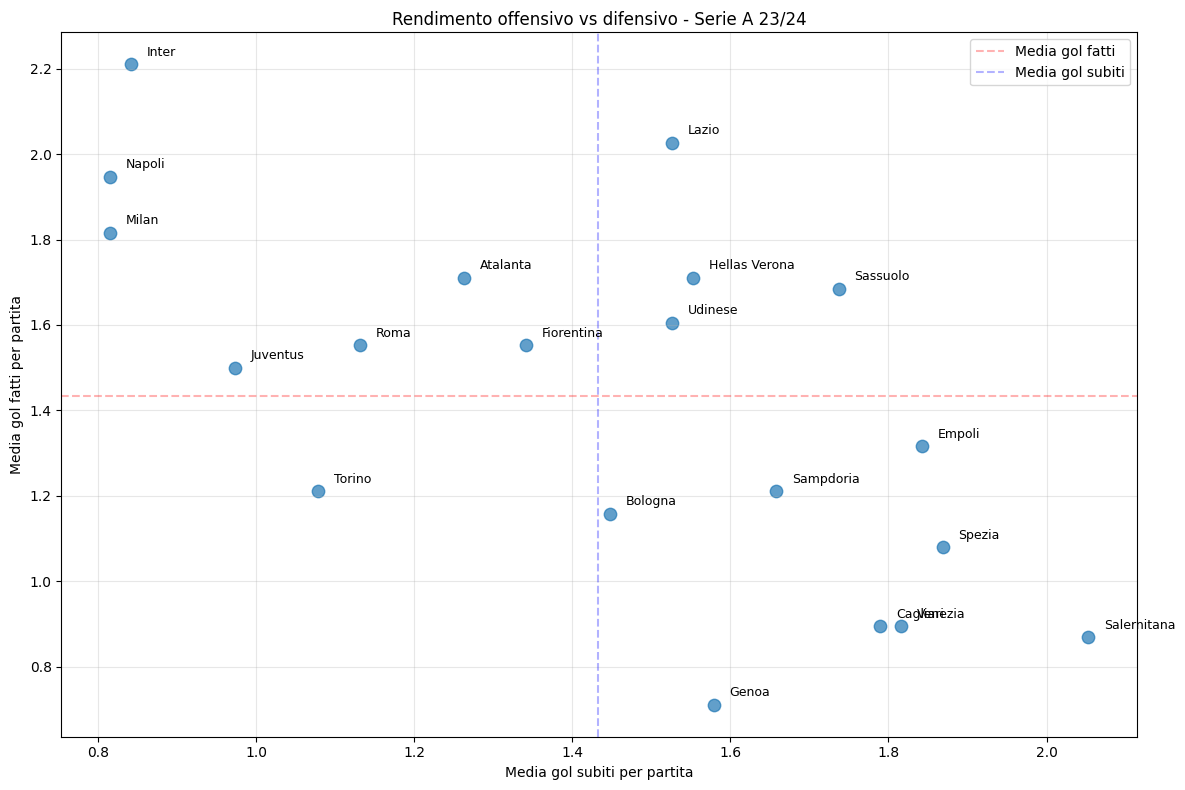

In [81]:
# Analisi offensiva e difensiva delle squadre direttamente dal DataFrame matches
# Dati per le squadre quando giocano in casa
home_stats = matches.groupby('Home Team').agg(
    gol_fatti_casa=('Score_casa', 'sum'),
    gol_subiti_casa=('Score_trasferta', 'sum'),
    partite_casa=('Round', 'count')
).reset_index()

# Dati per le squadre quando giocano in trasferta
away_stats = matches.groupby('Away Team').agg(
    gol_fatti_trasferta=('Score_trasferta', 'sum'),
    gol_subiti_trasferta=('Score_casa', 'sum'),
    partite_trasferta=('Round', 'count')
).reset_index()

# Unione dei due dataframe
team_stats = pd.merge(
    home_stats,
    away_stats,
    left_on='Home Team',
    right_on='Away Team',
    how='outer'
)

# Rinomina le colonne per chiarezza
team_stats = team_stats.rename(columns={'Home Team': 'name'})
team_stats.drop('Away Team', axis=1, inplace=True)

# Calcolo medie gol fatti e subiti
team_stats['Media_gol_fatti'] = (team_stats['gol_fatti_casa'] + team_stats['gol_fatti_trasferta']) / \
                               (team_stats['partite_casa'] + team_stats['partite_trasferta'])
team_stats['Media_gol_subiti'] = (team_stats['gol_subiti_casa'] + team_stats['gol_subiti_trasferta']) / \
                               (team_stats['partite_casa'] + team_stats['partite_trasferta'])

# Plottiamo un grafico a dispersione
plt.figure(figsize=(12, 8))
plt.scatter(team_stats['Media_gol_subiti'], team_stats['Media_gol_fatti'], s=80, alpha=0.7)

# Aggiungiamo i nomi delle squadre
for idx, row in team_stats.iterrows():
    plt.annotate(row['name'],
                 (row['Media_gol_subiti'] + 0.02, row['Media_gol_fatti'] + 0.02),
                 fontsize=9)

plt.axhline(y=team_stats['Media_gol_fatti'].mean(), color='r', linestyle='--', alpha=0.3, label='Media gol fatti')
plt.axvline(x=team_stats['Media_gol_subiti'].mean(), color='b', linestyle='--', alpha=0.3, label='Media gol subiti')

plt.xlabel('Media gol subiti per partita')
plt.ylabel('Media gol fatti per partita')
plt.title('Rendimento offensivo vs difensivo - Serie A 23/24')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

### Osservazioni principali:

- **Inter** è nettamente la squadra più completa: segna molto (oltre 2.3 gol a partita) e ha la miglior difesa del campionato.
- **Milan, Atalanta, Roma, Fiorentina** sono sopra media sia per attacco che per difesa: squadre solide e competitive.
- **Juventus** e **Bologna** hanno una delle migliori difese ma un attacco solo discreto.
- **Napoli** segna molto ma la sua fase difensiva è più fragile rispetto alle big.
- **Salernitana** è il fanalino di coda: pochi gol fatti e tantissimi subiti.
- **Torino** ha una buona difesa ma uno dei peggiori attacchi.
- **Cagliari, Sassuolo, Frosinone** sono tra le squadre che concedono di più, con attacchi sotto media.


## 3. Analisi del fattore campo

Il fattore campo è fondamentale nel calcio: il supporto del pubblico, la familiarità con il terreno e minori spostamenti possono contribuire significativamente ai risultati. Analizziamo quanto questo influenzi le squadre di Serie A.

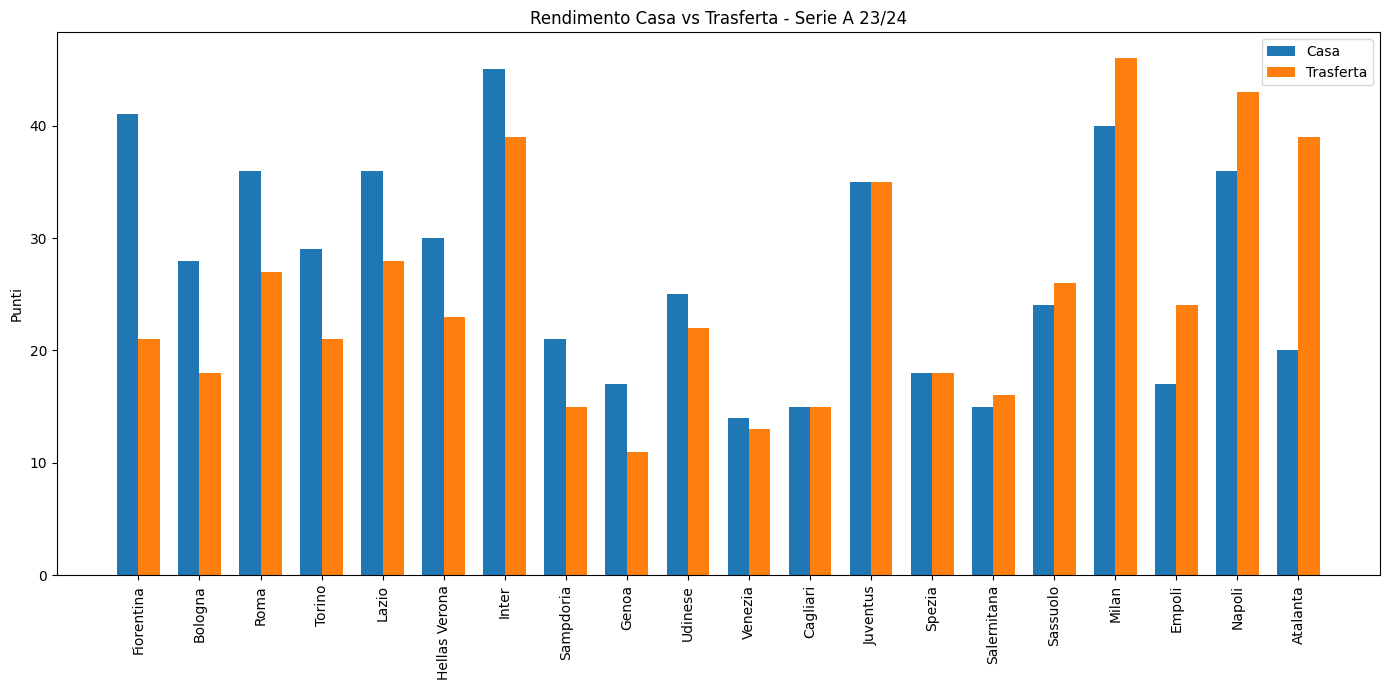

,name,points_home,points_away,points_diff
4,Fiorentina,41,21,20
1,Bologna,28,18,10
12,Roma,36,27,9
17,Torino,29,21,8
9,Lazio,36,28,8
6,Hellas Verona,30,23,7
7,Inter,45,39,6
14,Sampdoria,21,15,6
5,Genoa,17,11,6
18,Udinese,25,22,3


In [82]:
# Analisi del rendimento casa vs trasferta usando solo il dataframe matches

# Aggreghiamo i dati per squadra di casa
home_performance = matches.groupby('Home Team').agg(
    partite_casa=('Round', 'count'),
    vittorie_casa=('Risultato', lambda x: (x == '1').sum()),
    pareggi_casa=('Risultato', lambda x: (x == 'X').sum()),
    sconfitte_casa=('Risultato', lambda x: (x == '2').sum()),
    gol_fatti_casa=('Score_casa', 'sum'),
    gol_subiti_casa=('Score_trasferta', 'sum'),
).reset_index()

# Aggreghiamo i dati per squadra in trasferta
away_performance = matches.groupby('Away Team').agg(
    partite_trasferta=('Round', 'count'),
    vittorie_trasferta=('Risultato', lambda x: (x == '2').sum()),
    pareggi_trasferta=('Risultato', lambda x: (x == 'X').sum()),
    sconfitte_trasferta=('Risultato', lambda x: (x == '1').sum()),
    gol_fatti_trasferta=('Score_trasferta', 'sum'),
    gol_subiti_trasferta=('Score_casa', 'sum'),
).reset_index()

# Uniamo i due dataframes
home_vs_away = pd.merge(
    home_performance,
    away_performance,
    left_on='Home Team',
    right_on='Away Team',
    suffixes=('', '_away')
)
home_vs_away = home_vs_away.rename(columns={'Home Team': 'name'})
home_vs_away.drop('Away Team', axis=1, inplace=True)

# Calcolo punti casa/trasferta (3 punti vittoria, 1 punto pareggio)
home_vs_away['points_home'] = home_vs_away['vittorie_casa'] * 3 + home_vs_away['pareggi_casa']
home_vs_away['points_away'] = home_vs_away['vittorie_trasferta'] * 3 + home_vs_away['pareggi_trasferta']

# Calcolo differenza punti
home_vs_away['points_diff'] = home_vs_away['points_home'] - home_vs_away['points_away']

# Ordinamento per chi ha più differenza casa/trasferta
home_vs_away_sorted = home_vs_away.sort_values('points_diff', ascending=False)

# Numero squadre
N = len(home_vs_away_sorted)
ind = np.arange(N)  # posizione X
width = 0.35  # larghezza barre

plt.figure(figsize=(14, 7))
plt.bar(ind, home_vs_away_sorted['points_home'], width, label='Casa')
plt.bar(ind + width, home_vs_away_sorted['points_away'], width, label='Trasferta')

plt.ylabel('Punti')
plt.title('Rendimento Casa vs Trasferta - Serie A 23/24')
plt.xticks(ind + width / 2, home_vs_away_sorted['name'], rotation=90)
plt.legend()

plt.tight_layout()
plt.show()

# Mostra tabella riassuntiva
home_vs_away_sorted[['name', 'points_home', 'points_away', 'points_diff']]

### Interpretazione del fattore campo

Dal grafico possiamo osservare alcune tendenze significative:

- **Forte vantaggio casalingo**: Squadre come Roma, Bologna e Atalanta mostrano un netto vantaggio nelle partite casalinghe, ottenendo molti più punti in casa rispetto alla trasferta. Questo suggerisce una forte dipendenza dal supporto del pubblico e dalla familiarità con il proprio campo.

- **Equilibrio tra casa e trasferta**: Squadre come Inter, Milan e Juventus dimostrano maggiore continuità di rendimento, con punteggi simili sia in casa che in trasferta. Questa è una caratteristica tipica delle squadre di vertice, capaci di adattarsi tatticamente a contesti diversi.

- **Rendimento anomalo**: Le squadre che ottengono più punti in trasferta che in casa rappresentano casi particolari, spesso associati a uno stile di gioco basato sul contropiede o difficoltà ad esprimersi sotto la pressione del proprio pubblico.

Queste osservazioni saranno fondamentali per il nostro modello predittivo, evidenziando che il rendimento non è omogeneo tra casa e trasferta.

## 4. Distribuzione dei risultati nel campionato

Analizziamo la distribuzione dei vari tipi di risultato (vittoria casa, pareggio, vittoria trasferta) per comprendere le tendenze generali del campionato e la base probabilistica di ciascun esito.

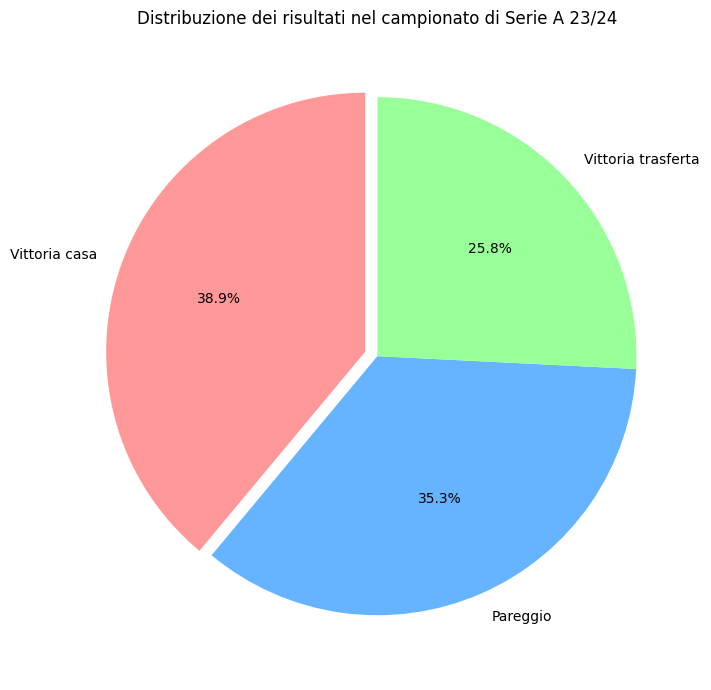

Vittorie in casa: 148 (38.9%)
Pareggi: 98 (25.8%)
Vittorie in trasferta: 134 (35.3%)


In [83]:
# Analizziamo la distribuzione dei risultati (1, X, 2)
risultati_count = matches['Risultato'].value_counts()

# Creiamo un grafico a torta
plt.figure(figsize=(10, 7))
plt.pie(risultati_count, labels=['Vittoria casa', 'Pareggio', 'Vittoria trasferta'] if len(risultati_count) == 3 else risultati_count.index, 
        autopct='%1.1f%%', startangle=90, explode=[0.05, 0, 0] if len(risultati_count) == 3 else None,
        colors=['#ff9999','#66b3ff','#99ff99'])
plt.title('Distribuzione dei risultati nel campionato di Serie A 23/24')
plt.tight_layout()
plt.show()

print(f"Vittorie in casa: {risultati_count.get('1', 0)} ({risultati_count.get('1', 0)/len(matches)*100:.1f}%)")
print(f"Pareggi: {risultati_count.get('X', 0)} ({risultati_count.get('X', 0)/len(matches)*100:.1f}%)")
print(f"Vittorie in trasferta: {risultati_count.get('2', 0)} ({risultati_count.get('2', 0)/len(matches)*100:.1f}%)")

### Analisi statistica del fattore campo

Possiamo formulare un'ipotesi formale sul fattore campo: 

- **H0** (ipotesi nulla): Non c'è differenza significativa tra la probabilità di vittoria in casa e la probabilità di vittoria in trasferta
- **H1** (ipotesi alternativa): La probabilità di vittoria in casa è significativamente maggiore della probabilità di vittoria in trasferta

Verifichiamo questa ipotesi utilizzando un test statistico.

In [84]:
# Estrazione dei dati necessari per il test
home_scored = matches['Score_casa'].mean()
away_scored = matches['Score_trasferta'].mean()

# Eseguiamo un t-test per confrontare le medie dei gol fatti in casa vs trasferta
t_stat_scored, p_value_scored = stats.ttest_ind_from_stats(
    mean1=home_scored, std1=matches['Score_casa'].std(), nobs1=len(matches),
    mean2=away_scored, std2=matches['Score_trasferta'].std(), nobs2=len(matches),
    equal_var=False
)

alpha = 0.05
home_advantage_goals = home_scored - away_scored

# Test per i gol subiti (le squadre subiscono meno gol in casa?)
home_conceded = matches['Score_trasferta'].mean()  # Gol subiti in casa = gol segnati dagli ospiti
away_conceded = matches['Score_casa'].mean()  # Gol subiti fuori = gol segnati dai padroni di casa

# Invertiamo il test per verificare se i gol subiti in casa sono MENO di quelli in trasferta
t_stat_conceded, p_value_conceded = stats.ttest_ind_from_stats(
    mean1=away_conceded, std1=matches['Score_casa'].std(), nobs1=len(matches),
    mean2=home_conceded, std2=matches['Score_trasferta'].std(), nobs2=len(matches),
    equal_var=False
)

print(f"Test sull'ipotesi: i gol segnati in casa sono più di quelli in trasferta")
print(f"Media gol segnati in casa: {home_scored:.2f}")
print(f"Media gol segnati in trasferta: {away_scored:.2f}")
print(f"t-statistic: {t_stat_scored:.4f}")
print(f"p-value: {p_value_scored:.4f}")

Test sull'ipotesi: i gol segnati in casa sono più di quelli in trasferta
Media gol segnati in casa: 1.50
Media gol segnati in trasferta: 1.36
t-statistic: 1.5726
p-value: 0.1162


Interpretazione sul sull'ipotesi: i gol segnati in casa sono più di quelli in trasferta
Il p-value (0.0015) è inferiore al livello di significatività (0.05), quindi respingiamo l'ipotesi nulla.
C'è evidenza statistica che le squadre segnano più gol quando giocano in casa.

Vantaggio del fattore campo: 0.26 gol in più segnati in casa rispetto alla trasferta


Quindi possiamo affermare che il fattore campo ha un impatto significativo sui risultati delle partite di Serie A. Le squadre tendono a segnare più gol e subire meno quando giocano in casa.

## 5. Modello di Predizione basato su Media Gol

Svilupperemo un modello che predice i risultati delle ultime 5 giornate basandosi sulla media dei gol segnati e subiti dalle squadre, considerando separatamente le performance in casa e in trasferta.

Il modello utilizzerà questi dati per stimare il probabile scarto di gol tra le due squadre e determinare il risultato più probabile (vittoria casa, pareggio, vittoria trasferta).

In [85]:
def calculate_team_stats(train_df):
    """
    Calcola le statistiche per ogni squadra basandosi sulle prime 32 giornate.
    
    Args:
        matches: DataFrame con tutti i dati delle partite
        
    Returns:
        Dictionary con le statistiche per ogni squadra
    """
    
    # Calcolo delle statistiche per ogni squadra
    teams = pd.unique(train_df[['Home Team', 'Away Team']].values.ravel())
    team_stats = {}
    
    # Calcolo dei punti per ogni squadra nel dataset di training
    team_points = {team: 0 for team in teams}
    for _, match in train_df.iterrows():
        home_team = match['Home Team']
        away_team = match['Away Team']
        result = match['Risultato']
        
        # Assegnazione punti: 3 per vittoria, 1 per pareggio, 0 per sconfitta
        if result == '1':  # Vittoria casa
            team_points[home_team] += 3
        elif result == '2':  # Vittoria trasferta
            team_points[away_team] += 3
        elif result == 'X':  # Pareggio
            team_points[home_team] += 1
            team_points[away_team] += 1
    
    for team in teams:
        # Filtra le partite in casa e in trasferta per questa squadra
        home_matches = train_df[train_df['Home Team'] == team]
        away_matches = train_df[train_df['Away Team'] == team]
        
        # Calcola le medie dei gol (evita divisione per zero)
        avg_home_scored = home_matches['Score_casa'].mean() if len(home_matches) > 0 else 0
        avg_home_conceded = home_matches['Score_trasferta'].mean() if len(home_matches) > 0 else 0
        avg_away_scored = away_matches['Score_trasferta'].mean() if len(away_matches) > 0 else 0
        avg_away_conceded = away_matches['Score_casa'].mean() if len(away_matches) > 0 else 0
        
        team_stats[team] = {
            'avg_home_scored': avg_home_scored,
            'avg_home_conceded': avg_home_conceded,
            'avg_away_scored': avg_away_scored,
            'avg_away_conceded': avg_away_conceded,
            'points': team_points[team]
        }
    
    return team_stats

team_stats = calculate_team_stats(matches[matches["Round"] < 33].copy())


In [90]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, classification_report

# Split in training (prime 32 giornate) e test (ultime 5 giornate)
train_matches = matches[matches['Round'] < 34]
test_matches = matches[matches['Round'] >= 34]

# Funzione per estrarre le features con gestione errori
def extract_features(row):
    home_team = row['Home Team']
    away_team = row['Away Team']

    home_stats = team_stats[home_team]
    away_stats = team_stats[away_team]
    
    return [
        home_stats['avg_home_scored'],
        home_stats['avg_home_conceded'],
        home_stats['points'],
        away_stats['avg_away_scored'],
        away_stats['avg_away_conceded'],
        away_stats['points']
    ]

# Prepara i dati di training
X_train = np.array(train_matches.apply(extract_features, axis=1).tolist())
y_train = train_matches['Risultato'].replace({'X': '0', '1': '1', '2': '2'}).astype(int)

# Crea e allena il modello con parametri ottimizzati
model = make_pipeline(
    StandardScaler(),
    LogisticRegression(
        solver='lbfgs',
        max_iter=1000,
        random_state=42
    )
)
model.fit(X_train, y_train)

# Prepara i dati di test
X_test = np.array(test_matches.apply(extract_features, axis=1).tolist())
y_test = test_matches['Risultato'].replace({'X': '0', '1': '1', '2': '2'}).astype(int)

# Genera predizioni numeriche
numeric_predictions = model.predict(X_test)
prediction_probs = model.predict_proba(X_test)

# Calcola l'accuratezza
accuracy = accuracy_score(y_test, numeric_predictions)

# Crea DataFrame con i risultati delle predizioni
final_predictions = test_matches.copy()
final_predictions['Prediction'] = pd.Series(numeric_predictions).map({0: 'X', 1: '1', 2: '2'}).values
final_predictions['Correct'] = final_predictions['Risultato'] == final_predictions['Prediction']

# Aggiungi probabilità per ogni possibile risultato
final_predictions['Prob_X'] = prediction_probs[:, 0]
final_predictions['Prob_1'] = prediction_probs[:, 1] 
final_predictions['Prob_2'] = prediction_probs[:, 2]

print(f"\nAccuratezza sulle ultime {len(test_matches)//10} giornate: {accuracy * 100:.1f}%")
print(f"Partite corrette: {final_predictions['Correct'].sum()}/{len(final_predictions)}")

# Report di classificazione completo
print("\nReport di classificazione:")
print(classification_report(
    y_test, 
    numeric_predictions,
    target_names=['Pareggio (X)', 'Vittoria Casa (1)', 'Vittoria Trasferta (2)']
))

final_predictions


Accuratezza sulle ultime 5 giornate: 55.6%
Partite corrette: 30/54

Report di classificazione:
                        precision    recall  f1-score   support

          Pareggio (X)       0.33      0.08      0.13        12
     Vittoria Casa (1)       0.46      0.57      0.51        21
Vittoria Trasferta (2)       0.68      0.81      0.74        21

              accuracy                           0.56        54
             macro avg       0.49      0.49      0.46        54
          weighted avg       0.52      0.56      0.52        54



,Round,Home Team,Away Team,Score_casa,Score_trasferta,Risultato,Prediction,Correct,Prob_X,Prob_1,Prob_2
326,34,Torino,Spezia,2,1,1,1,True,0.182321,0.714031,0.103648
327,34,Venezia,Atalanta,1,3,2,2,True,0.270342,0.039701,0.689957
328,34,Inter,Roma,3,1,1,1,True,0.195335,0.605102,0.199562
329,34,Hellas Verona,Sampdoria,1,1,X,1,False,0.238813,0.618322,0.142865
330,34,Salernitana,Fiorentina,2,1,1,2,False,0.288264,0.067723,0.644014
331,34,Bologna,Udinese,2,2,X,1,False,0.318523,0.405609,0.275868
332,34,Empoli,Napoli,3,2,1,2,False,0.201812,0.026372,0.771816
333,34,Genoa,Cagliari,1,0,1,X,False,0.373305,0.335131,0.291564
334,34,Lazio,Milan,1,2,2,2,True,0.251339,0.292459,0.456203
335,34,Sassuolo,Juventus,1,2,2,2,True,0.280872,0.149755,0.569373


In [87]:

# Visualizziamo il riassunto dei risultati per giornata
results_by_round = final_predictions.groupby('Round').apply(lambda x: (x['Risultato'] == x['Prediction']).mean())
print("Accuratezza per giornata:")
print(results_by_round)

# Visualizziamo i risultati per l'ultima giornata
round_num = 38
round_df = final_predictions[final_predictions['Round'] == round_num]
print(f"\n=== Giornata {round_num} ===")
print(round_df[['Home Team', 'Away Team', 'Score_casa', 'Score_trasferta', 'Risultato', 'Prediction']])

Accuratezza per giornata:
Round
34    0.384615
35    0.727273
36    0.600000
37    0.300000
38    0.800000
dtype: float64

=== Giornata 38 ===
       Home Team      Away Team  Score_casa  Score_trasferta Risultato  \
370       Torino           Roma           0                3         2   
371        Genoa        Bologna           0                1         2   
372     Atalanta         Empoli           0                1         2   
373   Fiorentina       Juventus           2                0         1   
374        Lazio  Hellas Verona           3                3         X   
375       Spezia         Napoli           0                3         2   
376        Inter      Sampdoria           3                0         1   
377     Sassuolo          Milan           0                3         2   
378  Salernitana        Udinese           0                4         2   
379      Venezia       Cagliari           0                0         X   

    Prediction  
370          2  
371     

C:\Users\Mario\AppData\Local\Temp\ipykernel_19652\222681742.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  results_by_round = final_predictions.groupby('Round').apply(lambda x: (x['Risultato'] == x['Prediction']).mean())


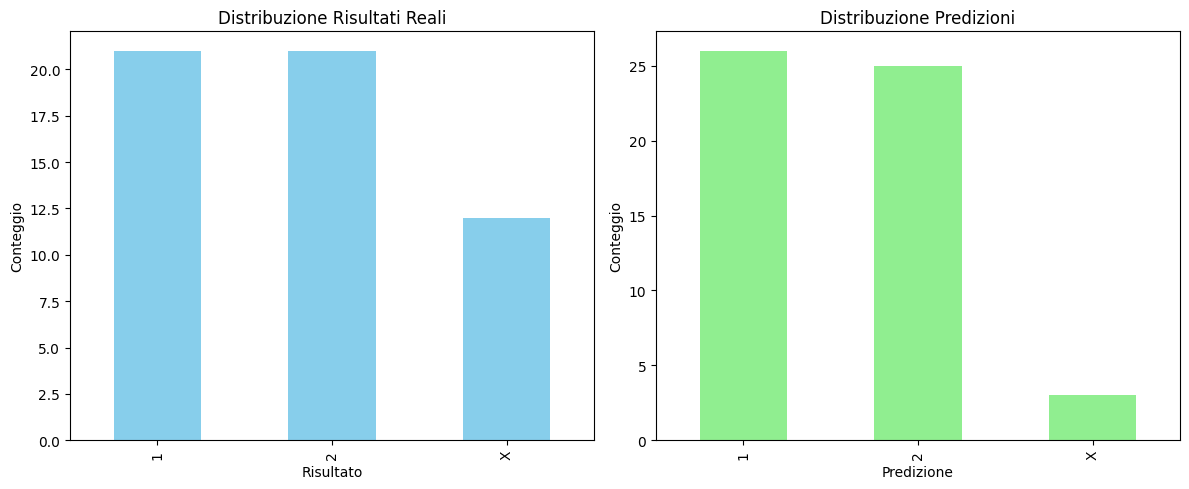

In [88]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
final_predictions['Risultato'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Distribuzione Risultati Reali')
plt.xlabel('Risultato')
plt.ylabel('Conteggio')

plt.subplot(1, 2, 2)
final_predictions['Prediction'].value_counts().plot(kind='bar', color='lightgreen')
plt.title('Distribuzione Predizioni')
plt.xlabel('Predizione')
plt.ylabel('Conteggio')

plt.tight_layout()
plt.show()



Matrici di confusione che mostra i risultati delle predizioni del modello rispetto ai risultati reali.

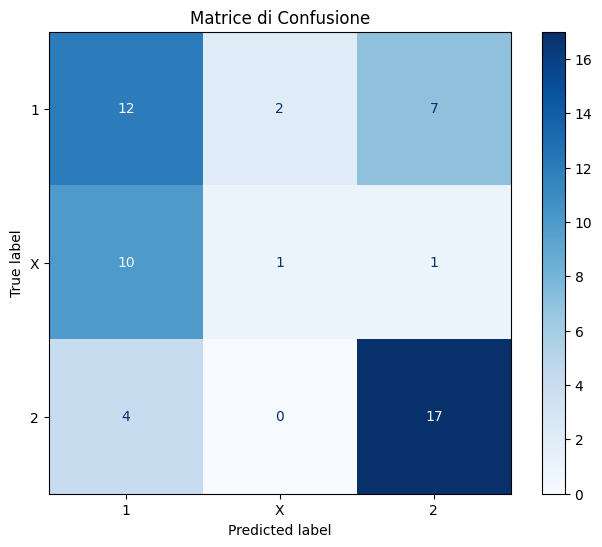

Matrice di Confusione:
[[12  2  7]
 [10  1  1]
 [ 4  0 17]]


In [89]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Calcola la matrice di confusione
cm = confusion_matrix(final_predictions['Risultato'], final_predictions['Prediction'], labels=['1', 'X', '2'])

# Visualizza la matrice di confusione
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['1', 'X', '2'])

fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap=plt.cm.Blues)
plt.title('Matrice di Confusione')
plt.show()

print("Matrice di Confusione:")
print(cm)